# Lung Cancer Survival Analysis

Table of Contents:
- [I. Set Up Workspace](i.set-up-workspace)
- [II. Data Profile](ii.data-profile)
    - [II.a Description](ii.a-description)
    - [II.b Dimensions](ii.b-dimensions)
    - [II.c Missingness](ii.c-missingness)
- [III. Data Imputation](iii.data-imputation)
    - [III.a Categorical Data](iii.a-impute-categorical-data)
        - [III.c.i Impute Categorical Data Using Mode](iii.c.i-impute-categorical-data-using-mode)
        - [III.c.ii Impute Categorical Data Using k-NN](iii.c.ii-impute-categorical-data-using-kNN)
        - [III.c.iii](iii.c.iii-test)
    - [III.b Continuous Data](iii.b-impute-continuous-data)
        - [III.b.i Impute Continuous Data Using Linear Regression](iii.c.i-impute-continuous-data-with-regression)
        - [III.c.ii](iii.c.ii-test)
- [IV. Data Exploration](ii.data-exploration)
- [IV. Data Modeling](ii.data-models)

## I. Set Up Workspace

In [5]:
# Import libraries
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype           # For ordered categoricals
from sklearn.model_selection import train_test_split
from scipy import stats                                 # For chi^2 contingency table
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter                       # For Cox-proportional Hazard Regression

In [6]:
# Load data
addy = 'assets/lung.csv'
df = pd.read_csv(addy, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 1 to 228
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 19.6 KB


Let's change the variable names containing dots to underscores.

In [7]:
df.rename(columns={'ph.ecog': 'ph_ecog', 'ph.karno': 'ph_karno',
                   'pat.karno': 'pat_karno' ,'meal.cal': 'meal_cal',
                   'wt.loss': 'wt_loss'}, inplace=True)
df.head()

,inst,time,status,age,sex,ph_ecog,ph_karno,pat_karno,meal_cal,wt_loss
1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


## II. Data Profile
### II.a Description

#### Data Description
Survival in patients with advanced lung cancer from the North Central Cancer Treatment Group.

#### Data Dictionary
- **inst** : Institution Code
- **time** : Surivival Time in Days
- **status** : Censoring Status
    - *1* = Censored
    - *2* = Dead
- **age** : Age in Years at Diagnosis
- **sex** : Patient's Sex
    - *1* = Male
    - *2* = Female
    - NOTE: The use of 1/2 for alive/dead instead of the usual 0/1 is a historical footnote. For data contained on punch cards, IBM 360 Fortran treated blank as a zero, which led to a policy within the section of Biostatistics to never use "0" as a data value since one could not distinguish it from a missing value. The policy became a habit, as is often the case; and the 1/2 coding endured long beyond the demise of punch cards and Fortran.
- **ph_ecog** : ECOG Performance Status
    - *0* = Fully active, able to carry on all pre-disease performance without restriction
    - *1* = Restricted in physically strenuous activity but ambulatory and able to carry out work of a light or sedentary nature, e.g., light house work, office work
    - *2* = Ambulatory and capable of all selfcare but unable to carry out any work activities. Up and about more than 50% of waking hours
    - *3* = Capable of only limited selfcare, confined to bed or chair more than 50% of waking hours
    - *4* = Completely disabled. Cannot carry on any selfcare. Totally confined to bed or chair
    - *5* = Dead
- **ph_karno** : Physician-rated Karnofsky Performance Status
    - A standard way of measuring the ability of cancer patients to perform ordinary tasks. May be used to determine a patient's prognosis, to measure changes in a patient’s ability to function, or to decide if a patient could be included in a clinical trial.
    - *100* = Normal, no complaints; no evidence of disease
    - *90* = Able to carry on normal activity; minor signs or symptoms of disease
    - *80* = Normal activity with effort, some signs or symptoms of disease
    - *70* = Cares for self but unable to carry on normal activity or to do active work
    - *60* = Requires occasional assistance but is able to care for most of personal needs
    - *50* = Requires considerable assistance and frequent medical care
    - *40* = Disabled; requires special care and assistance
    - *30* = Severely disabled; hospitalization is indicated although death not imminent
    - *20* = Very ill; hospitalization and active supportive care necessary
    - *10* = Moribund
    - *0* = Dead
- **pat_karno** : Patient-rated Karnofsky Performance Status
    - Same as ph.karno, but calculated by the patient
- **meal_cal** : Average Calories Consumed at Meals
- **wt_loss** : Weight Loss (last 6 months)

Data Source:
- [R NCCTG Lung Data](https://r-data.pmagunia.com/dataset/r-dataset-package-survival-lung)

Additional Information:
- [NCCTG Lung Cancer Data R Documentation](https://stat.ethz.ch/R-manual/R-devel/library/survival/html/lung.html)
- [ECOG Performance Status](https://training.seer.cancer.gov/followup/procedures/dataset/ecog.html)
- [Karnofsky Performance Status](https://www.cancer.gov/publications/dictionaries/cancer-terms/def/karnofsky-performance-status)
- [Comparing ECOG to Karnofsky](https://ecog-acrin.org/resources/ecog-performance-status)

In [8]:
# Check data
df.head()

,inst,time,status,age,sex,ph_ecog,ph_karno,pat_karno,meal_cal,wt_loss
1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [9]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 1 to 228
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph_ecog    227 non-null    float64
 6   ph_karno   227 non-null    float64
 7   pat_karno  225 non-null    float64
 8   meal_cal   181 non-null    float64
 9   wt_loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 19.6 KB


Above, we can see that some of these data have incorrect data types. For those that are categorical, we will use the categorical feature of pandas. Let's change the data types of the following categorical variables:

- Change to unordered 'category'
    - inst
    - status
    - sex
    - ph_ecog
    - ph_karno
    - pat_karno


NOTE: After the missing data has been handled, the following variables will be cast as ordered 'category':
- ph_ecog
- ph_karno
- pat_karno

In [10]:
# Change data types
#-------------------------------------------------------------------------------

# NOTE: ph_ecog, ph.karno, and pat.karno will be cast as ordered categories
#       after the null values have been handled

# First, change floats to ints so we can drop the decimals
float_to_int_list = ['inst', 'ph_ecog', 'ph_karno', 'pat_karno']
df[float_to_int_list] = df[float_to_int_list].astype('Int8') # Int8 for nullable integer dtype

# Change dtypes to category
cat_vars = ['ph_ecog', 'ph_karno', 'pat_karno', 'inst', 'status', 'sex']
df[cat_vars] = df[cat_vars].astype('category')

# Check changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 1 to 228
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   inst       227 non-null    category
 1   time       228 non-null    int64   
 2   status     228 non-null    category
 3   age        228 non-null    int64   
 4   sex        228 non-null    category
 5   ph_ecog    227 non-null    category
 6   ph_karno   227 non-null    category
 7   pat_karno  225 non-null    category
 8   meal_cal   181 non-null    float64 
 9   wt_loss    214 non-null    float64 
dtypes: category(6), float64(2), int64(2)
memory usage: 11.9 KB


### II.b Dimensions

In [11]:
# Describe dimensions of data
#-------------------------------------------------------------------------------

# Find the number of columns, rows, and elements in the df
num_elems = df.size
num_rows = df.shape[0]
num_cols = df.shape[1]

# Print dimensions
tab = ' '   # Tab character for formatting output
print(f'Data Frame Dimensions:\n'
      f'{tab*2}- {num_elems:,} elements\n'
      f'{tab*2}- {num_cols:,} columns\n'
      f'{tab*2}- {num_rows:,} rows\n'
      f'{tab*4}- Begins with column: {df.columns[0]}\n'
      f'{tab*4}- Ends with column: {df.columns[num_cols-1]}')

Data Frame Dimensions:
  - 2,280 elements
  - 10 columns
  - 228 rows
    - Begins with column: inst
    - Ends with column: wt_loss


In [12]:
# Print descriptive stats for numerical and categorical data
desc_stats_num = df.describe()
desc_stats_cat = df.describe(include=['category'])
tab = ' '
print(f'Descriptive Statistics for the Entire Data Set:\n\n'
      f'{tab*2}Numerical Data:\n'
      f'{desc_stats_num}\n\n'
      f'{tab*2}Categorical Data:\n'
      f'{desc_stats_cat}')

Descriptive Statistics for the Entire Data Set:

  Numerical Data:
              time         age     meal_cal     wt_loss
count   228.000000  228.000000   181.000000  214.000000
mean    305.232456   62.447368   928.779006    9.831776
std     210.645543    9.073457   402.174707   13.139902
min       5.000000   39.000000    96.000000  -24.000000
25%     166.750000   56.000000   635.000000    0.000000
50%     255.500000   63.000000   975.000000    7.000000
75%     396.500000   69.000000  1150.000000   15.750000
max    1022.000000   82.000000  2600.000000   68.000000

  Categorical Data:
        inst  status  sex  ph_ecog  ph_karno  pat_karno
count    227     228  228      227       227        225
unique    18       2    2        4         6          8
top        1       2    1        1        90         90
freq      36     165  138      113        74         60


### II.c Missingness

Check for missing values

<AxesSubplot:>

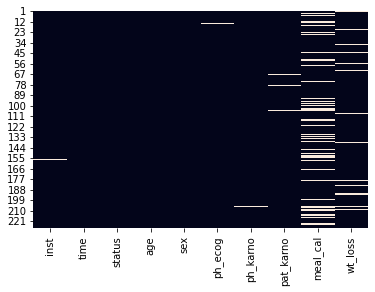

In [13]:
# Check for missing values visually w/ heatmap
sns.heatmap(df.isna(), cbar=False)
#TODO: Change dimensions of plot
#TODO: Add title, x/y-axis labels to plot

As can be seen in the plot above, there are, in fact, missing values in this data set.

Results from models with missing data could potentially include biased point estimates and standard errors, as well as, loss of statistical power to detect associations. It is important to note tht the impact of missing data does not depend only on the percentage of missing values. The underylying reasons for why the data are missing must be considered. The following is an overview of types of missing data:

#### There are 3 types of missing data:

- **Missing Completely At Random (MCAR)**
    - The fact that MCAR data are missing is independent of the observed and unobserved data. This is to say, patients with missing data are not systematically different from patients with no missing data.
        - EG: Patients with missing lab results because of a lab technician's error are not systematically different from patients with no missing lab results. In this scenario, the reason for the missing data is not dependent on the observed or the unobserved data. The missingness is unrelated to the subject being studied.
#
- **Missing At Random (MAR)**
    - The fact that MAR data are missing is systematically related to the observed data, but not the unobserved data. That is to say, patients with missing data are systematically related to observed data, but not unobserved data.
        - EG: Patients with missing follow up data might be systemically different from patients with no missing data because those with missing data were related to poorer heath status.
#    
- **Missing Not At Random (MNAR)**
    - The fact that MNAR data are missing is systematically related to the unobserved data, but not the observed data. That is to say, patients with missing data are systematically related to unobserved data, but not observed data. The missingness is related to factors that are not measured by the researcher.
        - EG: Survey data for patients with depression might be missing because patients with depression are less likely to complete the survey.


In [14]:
# Check for missing values
#-------------------------------------------------------------------------------

# Check number & percentage of total na's in df
num_elems = df.size
total_num_nas = df.isna().sum().sum()
total_perc_na = total_num_nas / num_elems

# Print above numbers
print(f'Missing Data By Element: \n'
      f'{total_num_nas: ,}, or {total_perc_na: .1%}, of the {num_elems: ,} '
      f'elements in the dataframe are null\n')

Missing Data By Element: 
 67, or  2.9%, of the  2,280 elements in the dataframe are null



In [15]:
# Create dataframe of missing values
missing_df = df[df.isnull().any(axis=1)]
missing_df.head(1)

,inst,time,status,age,sex,ph_ecog,ph_karno,pat_karno,meal_cal,wt_loss
1,3,306,2,74,1,1,90,100,1175.0,NaN


In [16]:
# Print descriptive stats of missing data df
#TODO: Can I use describe to get stats for missing data?
missing_df_desc = missing_df.describe()
missing_df_desc_cat = missing_df.describe(include='category')
tab = ' '
print(f'Descriptive Stats for Observations Missing Data:\n\n'
      f'{tab*2}Numerical:\n'
      f'{missing_df_desc}\n\n'
      f'{tab*2}Categorical:\n'
      f'{missing_df_desc_cat}')

Descriptive Stats for Observations Missing Data:

  Numerical:
              time        age     meal_cal    wt_loss
count    61.000000  61.000000    14.000000  47.000000
mean    292.360656  62.114754   924.642857  10.234043
std     215.144915   8.752330   237.307203  12.383742
min      11.000000  40.000000   513.000000 -11.000000
25%     144.000000  56.000000   726.500000   0.000000
50%     208.000000  62.000000  1025.000000   7.000000
75%     371.000000  69.000000  1075.000000  17.000000
max    1010.000000  81.000000  1225.000000  49.000000

  Categorical:
        inst  status  sex  ph_ecog  ph_karno  pat_karno
count     60      61   61       60        60         58
unique    15       2    2        3         6          6
top        1       2    1        1        90         90
freq       8      45   35       32        24         16


Missing Data by Column

In [17]:
# Describe missing data by column
#-------------------------------------------------------------------------------

# Check number & percentage of na's per column
# Create series containing number of na's in each column
na_series = df.isna().sum()
# Subset series to include only columns that have na's
cols_w_nas = na_series[na_series > 0].sort_values(ascending=False)
# Calculate numbers of columns w/ and w/o na's & percentages
num_cols = df.shape[1]
num_cols_w_nas = len(cols_w_nas)
num_cols_wo_nas = num_cols - num_cols_w_nas
perc_cols_w_nas = num_cols_w_nas / num_cols
perc_cols_wo_nas = num_cols_wo_nas / num_cols
# Print above numbers
tab = ' '
print(f'Missing Data By Column:')
print(f'{tab*2}-{num_cols_wo_nas: ,}, or{perc_cols_wo_nas: .1%}, of '
      f'the{num_cols: ,} columns do not contain null values\n'
      f'{tab*2}-{num_cols_w_nas: ,}, or{perc_cols_w_nas: .1%}, of '
      f'the{num_cols: ,} columns contain null values\n')

# Print column names with data types, number of na's and percentage of na's
missing_data_desc_col = []
headers_col = ['Column Name', 'Data Type', '# Na\'s', '% Na\'s']

# Loop through each column in df with na's
# Build table of missing data description by column
for col in cols_w_nas.index:
    num_nas_col = df[col].isna().sum()
    perc_nas_col = (num_nas_col / num_elems) * 100
    data_type = df[col].dtype
    missing_data_desc_col.append([col, data_type, num_nas_col, perc_nas_col])

# Print table
num_format_col = ['.0f', '.1f']
print(tabulate(missing_data_desc_col, headers=headers_col, tablefmt='fancy', 
               floatfmt=num_format_col))

Missing Data By Column:
  - 4, or 40.0%, of the 10 columns do not contain null values
  - 6, or 60.0%, of the 10 columns contain null values

Column Name    Data Type      # Na's     % Na's
-------------  -----------  --------  ---------
meal_cal       float64            47  2.0614
wt_loss        float64            14  0.614035
pat_karno      category            3  0.131579
inst           category            1  0.0438596
ph_ecog        category            1  0.0438596
ph_karno       category            1  0.0438596


Missing Data by Patient (row)

In [18]:
# Describe missing data by row (i.e. patient)
#-------------------------------------------------------------------------------

# Create a dataframe of patients with missing data

# Check number & percentage of na's per column
# Create series containing number of na's in each column
na_series_row = df.isna().sum(axis=1)
# Subset series to include only columns that have na's and sort from max to min
rows_w_nas = na_series_row[na_series_row > 0].sort_values(ascending=False)

# Calculate number and percentage of na's per row
num_rows = df.shape[0]
num_rows_w_nas = len(rows_w_nas)
num_rows_wo_nas = num_rows - num_rows_w_nas
perc_rows_w_nas = num_rows_w_nas / num_rows
perc_rows_wo_nas = num_rows_wo_nas / num_rows

# Create df of missing data
missing_df = pd.DataFrame()
# Include number and percentge of NA's
missing_df['# Na\'s'] = rows_w_nas
missing_df['% Na\'s'] = (missing_df['# Na\'s'] / num_cols) * 100
# Left join df subsetting by rows with missing data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
missing_df = missing_df.join(df.iloc[rows_w_nas.index - 1])

# Print number and percentage of na's per  
print(f'Missing Data By Patient (row):')
print(f'\n{tab*2}-{num_rows_wo_nas: ,}, or{perc_cols_wo_nas: .1%}, '
      f'of the{num_rows: ,} rows do not contain null values\n'
      f'{tab*2}-{num_rows_w_nas: ,}, or{perc_rows_w_nas: .1%}, '
      f'of the{num_rows: ,} rows contain null values')

# Print the data frame
print(f'\nMissing Data Dataframe (partial):')
missing_df.head()

# NOTE: The entire df can be printed using pd.option_context('display.max_rows')

Missing Data By Patient (row):

  - 167, or 40.0%, of the 228 rows do not contain null values
  - 61, or 26.8%, of the 228 rows contain null values

Missing Data Dataframe (partial):


,# Na's,% Na's,inst,time,status,age,sex,ph_ecog,ph_karno,pat_karno,meal_cal,wt_loss
206,3,30.0,33,105,2,62,1,2,NaN,70,NaN,NaN
178,2,20.0,13,186,2,55,2,1,80,70,NaN,NaN
105,2,20.0,13,177,2,59,1,2,50,NaN,NaN,32.0
44,2,20.0,12,145,2,60,2,2,70,60,NaN,NaN
209,2,20.0,21,237,1,69,1,1,80,70,NaN,NaN


Missing Data by Institution

In [19]:
# Missing data by inst
#-------------------------------------------------------------------------------

# Print variable by which missing data is grouped
print(f'Missing Data by Institution\n')

# Descriptive stats of inst data from observations with missing data
inst_desc_stat = missing_df[['inst']].describe(include=['category'])
print(f'Descriptive Statistics of inst Variable for Observations with Missing Data:\n'
      f'{inst_desc_stat}\n')

# Count the number of na's per inst value
group_inst = missing_df[['# Na\'s', 'inst']].groupby(['inst']).sum().astype('int64')

# Calculate percentage total of na's by inst
total_na = missing_df.isna().sum().sum()
group_inst['% Na\'s'] = ((group_inst['# Na\'s'] / total_na) * 100).round(1)

# Print transform of group_inst
print(f'Number & Percentage of Missing Values by Institution:\n'
      f'{group_inst.T}\n')

# Calculate percentage of na's of inst data and total na's
num_inst_nas = missing_df['inst'].isna().sum()
num_nas_inst_na = df[df['inst'].isna()].isna().sum().sum().astype('int') - num_inst_nas
perc_inst_nas = (num_inst_nas / df.shape[0]) * 100
perc_nas_inst_na = (num_nas_inst_na / total_na) * 100

# Print num, percentage of na's
tab = ' '
print(f'Missing Institution Data:\n'
      f'{tab*2}-{num_inst_nas: ,}, or{perc_inst_nas: ,.1f} percent, of inst data is missing\n'
      f'{tab*2}-{num_nas_inst_na: ,}, or{perc_nas_inst_na: ,.1f} percent, of all missing data occur '
      f'when values for inst are missing\n')

#NOTE: df.groupby(by="a", dropna=False).sum()

Missing Data by Institution

Descriptive Statistics of inst Variable for Observations with Missing Data:
        inst
count     60
unique    15
top        1
freq       8

Number & Percentage of Missing Values by Institution:
inst       1    2     3    4    5    6    7   10   11    12    13   15   16  \
# Na's   8.0  1.0   7.0  0.0  2.0  2.0  1.0  0.0  5.0   8.0   9.0  0.0  6.0   
% Na's  11.9  1.5  10.4  0.0  3.0  3.0  1.5  0.0  7.5  11.9  13.4  0.0  9.0   

inst     21   22   26   32   33  
# Na's  6.0  4.0  2.0  1.0  4.0  
% Na's  9.0  6.0  3.0  1.5  6.0  

Missing Institution Data:
  - 1, or 0.4 percent, of inst data is missing
  - 0, or 0.0 percent, of all missing data occur when values for inst are missing



Missing Data by Patient Status

In [38]:
# Missing data by patient status
#-------------------------------------------------------------------------------

# Print variable by which missing data is grouped
print(f'Missing Data by Patient Status\n')

# Calc number and percentage of missing values
num_status_nas = missing_df['status'].isna().sum()
perc_nas_status = (num_status_nas / df.shape[0]) * 100

# Descriptive stats of status data from observations with missing data
status_desc_stats = missing_df[['status']].describe(include=['category'])
print(f'Descriptive Statistics of status Variable for Observations Missing Data:\n'
      f'{status_desc_stats}\n')

# Count the number of na's per status
group_status = missing_df[['# Na\'s', 'status']].groupby(['status']).sum()
print(f'Number of Missing Values Grouped by Status Variable:\n'
      f'{group_status}\n')

# Calculate percentage of na's of inst data and total na's
num_status_nas = missing_df['status'].isna().sum()
perc_nas_status = (num_status_nas / df.shape[0]) * 100
num_nas_when_status_na = df[df['status'].isna()].isna().sum().sum().astype('int')
perc_nas_when_status_na = (num_nas_when_status_na / total_na) * 100 \
                                                    if num_nas_when_status_na > 0 else 0

# Calculate percentage of na's per status
total_na = df.isna().sum().sum()
perc_nas_status_1 = (group_status.at[1, '# Na\'s'] / total_na) * 100
perc_nas_status_2 = (group_status.at[2, '# Na\'s'] / total_na) * 100

# List var's which have missing data and count number of missing val's for each
vars_nas_status_1 = df[df['status'] == 1].isna().sum().sort_values(ascending=False)
vars_nas_status_1 = vars_nas_status_1[vars_nas_status_1 > 0]
vars_nas_status_2 = df[df['status'] == 2].isna().sum().sort_values(ascending=False)
vars_nas_status_2 = vars_nas_status_2[vars_nas_status_2 > 0]
vars_nas_status_2

# Print num's and percentages na's
tab = ' '
print(f'Missing Data by Patient Status:\n'
      f'{tab*2}- {num_status_nas:,}, or {perc_nas_status:,.1f} percent of '
      f'status data are missing\n'
      f'{tab*2}- {num_nas_when_status_na:,}, or{perc_nas_when_status_na: ,.1f} percent of all '
      f'missing data occur when values for status are missing\n'
      f'{tab*2}-{perc_nas_status_1: .1f} percent of the null values occur when '
      f'the patient has a status of 1 (censored)\n'
      f'{tab*2}-{perc_nas_status_2: .1f} percent of the null values occur when '
      f'the patient has a status of 2 (dead)')
#TODO: Add the numbers of missing data per status in the last 2 lines above

Missing Data by Patient Status

Descriptive Statistics of status Variable for Observations Missing Data:
        status
count       61
unique       2
top          2
freq        45

Number of Missing Values Grouped by Status Variable:
        # Na's
status        
1           17
2           50

Missing Data by Patient Status:
  - 0, or 0.0 percent of status data are missing
  - 0, or 0.0 percent of all missing data occur when values for status are missing
  - 25.4 percent of the null values occur when the patient has a status of 1 (censored)
  - 74.6 percent of the null values occur when the patient has a status of 2 (dead)


Missing Data by Patient Sex

In [21]:
# Missing data by patient sex
#-------------------------------------------------------------------------------

# Print variable for which missing data by which missing data is grouped
print(f'Missing Data by Patient Sex\n')

# Descriptive stats of sex data from observations with missing data
sex_desc_stat = missing_df[['sex']].describe(include=['category'])
print(f'Descriptive Statistics of sex Variable for Observations with Missing Data:\n'
      f'{sex_desc_stat}\n')

# Count the number of na's per sex
group_sex = missing_df[['# Na\'s', 'sex']].groupby(['sex']).sum()
print(f'Number of Missing Values Grouped by Sex Variable:\n'
      f'{group_sex}')

# Calculate percentage of na's per status
total_na = missing_df['# Na\'s'].sum()
perc_nas_sex_1 = (group_sex.at[1, '# Na\'s'] / total_na) * 100
perc_nas_sex_2 = (group_sex.at[2, '# Na\'s'] / total_na) * 100

# Print percentages
tab = ' '
print(f'\nMissing Data by Patient Sex:\n'
      f'{tab*2}-{perc_nas_sex_1: .1f} percent of the null values occur when '
      f'the patient has a sex of 1 (male)\n'
      f'{tab*2}-{perc_nas_sex_2: .1f} percent of the null values occur when '
      f'the patient has a sex of 2 (female)')
#TODO: Add num, percent of sex data missing
#TODO: Add num, percent of na's that occur when sex is missing

Missing Data by Patient Sex

Descriptive Statistics of sex Variable for Observations with Missing Data:
        sex
count    61
unique    2
top       1
freq     35

Number of Missing Values Grouped by Sex Variable:
     # Na's
sex        
1        39
2        28

Missing Data by Patient Sex:
  - 58.2 percent of the null values occur when the patient has a sex of 1 (male)
  - 41.8 percent of the null values occur when the patient has a sex of 2 (female)


Missing Data by Patient Age

In [22]:
# Missing data by patient age
#-------------------------------------------------------------------------------

# Print variable by which missing data is grouped
print(f'Missing Data by Patient Age\n')

# Descriptive stats of sex data from observations with missing data
age_desc_stat = missing_df[['age']].describe()
print(f'Descriptive Statistics of age Variable for Observations Missing Data:\n'
      f'{age_desc_stat}\n')

# Bin age data
missing_df['age_bin'] = pd.cut(missing_df['age'], 4,
                                labels=['1', '2', '3', '4'],
                                include_lowest=True)

# Descriptive stats for observations with missing data
age_bins_stats = missing_df['age_bin'].describe()
print(f'Descriptive Stats of Age Bins:\n'
      f'{age_bins_stats}\n')

# Number and percent of missing age data
num_age_na = missing_df['age'].isna().sum()
perc_age_na = (num_age_na / df.shape[0]) * 100
num_nas_when_age_na = (missing_df[missing_df['age'].isna()].isna().sum().sum() \
                                            - num_age_na).astype(int)
perc_nas_when_age_na = (num_nas_when_age_na / df.shape[0]) * 100

# Number of na's per age bin
num_nas_age_1 = missing_df[missing_df['age_bin'] == '1'].isna().sum().sum()
num_nas_age_2 = missing_df[missing_df['age_bin'] == '2'].isna().sum().sum()
num_nas_age_3 = missing_df[missing_df['age_bin'] == '3'].isna().sum().sum()
num_nas_age_4 = missing_df[missing_df['age_bin'] == '4'].isna().sum().sum()

# Percent of total na's per age bin
perc_nas_age_1 = (num_nas_age_1 / total_na) * 100
perc_nas_age_2 = (num_nas_age_2 / total_na) * 100
perc_nas_age_3 = (num_nas_age_3 / total_na) * 100
perc_nas_age_4 = (num_nas_age_4 / total_na) * 100

# Print num's and percentages
tab = ' '
print(f'Missing Data by Patient Age:\n'
      f'{tab*2}- {num_age_na:,}, or {perc_age_na:,.1f} percent of '
      f'age data are missing\n'
      f'{tab*2}- {num_nas_when_age_na:,}, or{perc_nas_when_age_na: ,.1f} percent of all missing '
      f'all missing data occur when values for age data are missing\n'
      f'{tab*2}- {num_nas_age_1}, or{perc_nas_age_1: .1f} percent of the null values occur when '
      f'the patient age is in bin 1\n'
      f'{tab*2}- {num_nas_age_2}, or{perc_nas_age_2: .1f} percent of the null values occur when '
      f'the patient age is in bin 2\n'
      f'{tab*2}- {num_nas_age_3}, or{perc_nas_age_3: .1f} percent of the null values occur when '
      f'the patient age is in bin 3\n'
      f'{tab*2}- {num_nas_age_4}, or{perc_nas_age_4: .1f} percent of the null values occur when '
      f'the patient age is in bin 4')
#TODO: Add the age ranges for each bin in print statements above
#NOTE: Should bin size equal 1 standard deviation?

Missing Data by Patient Age

Descriptive Statistics of age Variable for Observations Missing Data:
             age
count  61.000000
mean   62.114754
std     8.752330
min    40.000000
25%    56.000000
50%    62.000000
75%    69.000000
max    81.000000

Descriptive Stats of Age Bins:
count     61
unique     4
top        3
freq      23
Name: age_bin, dtype: object

Missing Data by Patient Age:
  - 0, or 0.0 percent of age data are missing
  - 0, or 0.0 percent of all missing data occur when values for age data are missing
  - 6, or 9.0 percent of the null values occur when the patient age is in bin 1
  - 25, or 37.3 percent of the null values occur when the patient age is in bin 2
  - 26, or 38.8 percent of the null values occur when the patient age is in bin 3
  - 10, or 14.9 percent of the null values occur when the patient age is in bin 4


Missing Data by Time

In [41]:
# Missing data by time
#-------------------------------------------------------------------------------

# Print variable by which missing data is grouped
print(f'Missing Data by Time\n')

# Descriptive stats of sex data from observations with missing data
time_desc_stat = missing_df[['time']].describe()
print(f'Descriptive Statistics of time Variable for Observations Missing Data:\n'
      f'{time_desc_stat}\n')

# Bin time data
missing_df['time_bin'] = pd.cut(missing_df['time'], 4, labels=['1', '2', '3', '4'],
                                 include_lowest=True)

time_bins_stats = missing_df['time_bin'].describe()
print(f'Descriptive Stats of Time Bins:\n'
      f'{time_bins_stats}\n')

# Number and percent of missing age data
num_time_na = missing_df['time'].isna().sum()
perc_time_na = (num_time_na / df.shape[0]) * 100
num_nas_when_time_na = (missing_df[missing_df['time'].isna()].isna().sum().sum() \
                                                - num_time_na).astype(int)
perc_nas_when_time_na = (num_nas_when_time_na / df.shape[0]) * 100
# Number of na's per age bin
num_nas_time_1 = missing_df[missing_df['time_bin'] == '1'].isna().sum().sum()
num_nas_time_2 = missing_df[missing_df['time_bin'] == '2'].isna().sum().sum()
num_nas_time_3 = missing_df[missing_df['time_bin'] == '3'].isna().sum().sum()
num_nas_time_4 = missing_df[missing_df['time_bin'] == '4'].isna().sum().sum()

#TODO: Calculate number of observations with missing values per time_bin using .shape[0]

# Percent of total na's per age bin
perc_nas_time_1 = (num_nas_time_1 / total_na) * 100
perc_nas_time_2 = (num_nas_time_2 / total_na) * 100
perc_nas_time_3 = (num_nas_time_3 / total_na) * 100
perc_nas_time_4 = (num_nas_time_4 / total_na) * 100

# Print num's and percentages na's
tab = ' '
print(f'Missing Data by Time Variable:\n'
      f'{tab*2}- {num_time_na:,}, or {perc_time_na:,.1f} percent of '
      f'time data are missing\n'
      f'{tab*2}- {num_nas_when_time_na:,}, or{perc_nas_when_time_na: ,.1f} percent of all '
      f'missing data occur when values for time are missing\n'
      f'{tab*2}- {num_nas_time_1}, or{perc_nas_time_1: .1f} percent of the null values occur when '
      f'the time is in bin 1\n'
      f'{tab*2}- {num_nas_time_2}, or{perc_nas_time_2: .1f} percent of the null values occur when '
      f'the time is in bin 2\n'
      f'{tab*2}- {num_nas_time_3}, or{perc_nas_time_3: .1f} percent of the null values occur when '
      f'the time is in bin 3\n'
      f'{tab*2}- {num_nas_time_4}, or{perc_nas_time_4: .1f} percent of the null values occur when '
      f'the time is in bin 4')
#TODO: Add the time ranges for each bin above
#NOTE: Should bin size equal 1 standard deviation?

Missing Data by Time

Descriptive Statistics of time Variable for Observations Missing Data:
              time
count    61.000000
mean    292.360656
std     215.144915
min      11.000000
25%     144.000000
50%     208.000000
75%     371.000000
max    1010.000000

Descriptive Stats of Time Bins:
count     61
unique     4
top        1
freq      34
Name: time_bin, dtype: object

Missing Data by Time Variable:
  - 0, or 0.0 percent of time data are missing
  - 0, or 0.0 percent of all missing data occur when values for time are missing
  - 75, or 111.9 percent of the null values occur when the time is in bin 1
  - 31, or 46.3 percent of the null values occur when the time is in bin 2
  - 18, or 26.9 percent of the null values occur when the time is in bin 3
  - 4, or 6.0 percent of the null values occur when the time is in bin 4


Missing Data by Physician ECOG

In [36]:
# Missing data by ph.ecog
#-------------------------------------------------------------------------------

# Print variable by which missing data is grouped
print(f'Missing Data by Physician ECOG\n')

# Descriptive stats of ph_ecog data from observations with missing data
ph_ecog_desc_stat = missing_df[['ph_ecog']].describe()
print(f'Descriptive Statistics of ph_ecog Variable for Observations Missing Data:\n'
      f'{ph_ecog_desc_stat}\n')

# Number and percent of missing ph_ecog data
num_ph_ecog_na = missing_df['ph_ecog'].isna().sum()
perc_ph_ecog_na = (num_ph_ecog_na / df.shape[0]) * 100
num_nas_when_ph_ecog_na = missing_df[missing_df['ph_ecog'].isna()].isna().sum().sum() \
                                                    - num_ph_ecog_na
perc_nas_when_ph_ecog_na = (num_nas_when_ph_ecog_na / df.shape[0]) * 100

# Number of na's per ph_ecog category
num_nas_ph_ecog_0 = missing_df[missing_df['ph_ecog'] == 0].isna().sum().sum()
num_nas_ph_ecog_1 = missing_df[missing_df['ph_ecog'] == 1].isna().sum().sum()
num_nas_ph_ecog_2 = missing_df[missing_df['ph_ecog'] == 2].isna().sum().sum()
num_nas_ph_ecog_3 = missing_df[missing_df['ph_ecog'] == 3].isna().sum().sum()
num_nas_ph_ecog_4 = missing_df[missing_df['ph_ecog'] == 4].isna().sum().sum()
num_nas_ph_ecog_5 = missing_df[missing_df['ph_ecog'] == 5].isna().sum().sum()

#TODO: Calculate number of observations with missing values per ph_ecog using .shape[0]

# Percent of total na's per ph_ecog category
perc_nas_ph_ecog_0 = (num_nas_ph_ecog_0 / total_na) * 100
perc_nas_ph_ecog_1 = (num_nas_ph_ecog_1 / total_na) * 100
perc_nas_ph_ecog_2 = (num_nas_ph_ecog_2 / total_na) * 100
perc_nas_ph_ecog_3 = (num_nas_ph_ecog_3 / total_na) * 100
perc_nas_ph_ecog_4 = (num_nas_ph_ecog_4 / total_na) * 100
perc_nas_ph_ecog_5 = (num_nas_ph_ecog_5 / total_na) * 100

# Print num's and percentages na's
tab = ' '
print(f'Missing Data by ph_ecog Variable:\n'
      f'{tab*2}- {num_ph_ecog_na:,}, or {perc_ph_ecog_na:,.1f} percent of '
      f'ph_ecog data are missing\n'
      f'{tab*2}- {num_nas_when_ph_ecog_na:,}, or{perc_nas_when_ph_ecog_na: ,.1f} percent of '
      f'all missing data occur when values for ph_ecog are missing\n'
      f'{tab*2}- {num_nas_ph_ecog_0}, or{perc_nas_ph_ecog_0: .1f} percent of the null values '
      f'occur when the ph_ecog is 0\n'
      f'{tab*2}- {num_nas_ph_ecog_1}, or{perc_nas_ph_ecog_1: .1f} percent of the null values '
      f'occur when the ph_ecog is 1\n'
      f'{tab*2}- {num_nas_ph_ecog_2}, or{perc_nas_ph_ecog_2: .1f} percent of the null values '
      f'occur when the ph_ecog is 2\n'
      f'{tab*2}- {num_nas_ph_ecog_3}, or{perc_nas_ph_ecog_3: .1f} percent of the null values '
      f'occur when the ph_ecog is 3\n'
      f'{tab*2}- {num_nas_ph_ecog_4}, or{perc_nas_ph_ecog_4: .1f} percent of the null values '
      f'occur when the ph_ecog is 4\n'
      f'{tab*2}- {num_nas_ph_ecog_5}, or{perc_nas_ph_ecog_5: .1f} percent of the null values '
      f'occur when the ph_ecog is 5\n')

Missing Data by Physician ECOG

Descriptive Statistics of ph_ecog Variable for Observations Missing Data:
        ph_ecog
count        60
unique        3
top           1
freq         32

Missing Data by ph_ecog Variable:
  - 1, or 0.4 percent of ph_ecog data are missing
  - 0, or 0.0 percent of all missing data occur when values for ph_ecog are missing
  - 31, or 46.3 percent of the null values occur when the ph_ecog is 0
  - 68, or 101.5 percent of the null values occur when the ph_ecog is 1
  - 28, or 41.8 percent of the null values occur when the ph_ecog is 2
  - 0.0, or 0.0 percent of the null values occur when the ph_ecog is 3
  - 0.0, or 0.0 percent of the null values occur when the ph_ecog is 4
  - 0.0, or 0.0 percent of the null values occur when the ph_ecog is 5



Missing Data by Physician Karnofsky Performance Score

In [35]:
# Missing data by ph_karno
#-------------------------------------------------------------------------------

# Print variable by which missing data is grouped
print(f'Missing Data by Physician Karnofsky Score\n')

# Descriptive stats of ph_ecog data from observations with missing data
ph_karno_desc_stat = missing_df[['ph_karno']].describe()
print(f'Descriptive Statistics of ph_karno Variable for Observations Missing Data:\n'
      f'{ph_karno_desc_stat}\n')

# Number and percent of missing ph_karno data
num_ph_karno_na = missing_df['ph_karno'].isna().sum()
perc_ph_karno_na = (num_ph_karno_na / df.shape[0]) * 100
# Number of na's that exist when ph_karno is missing
num_nas_when_ph_karno_na = missing_df[missing_df['ph_karno'].isna()].isna().sum().sum() \
                                                        - num_ph_karno_na
perc_nas_when_ph_karno_na = (num_nas_when_ph_karno_na / df.shape[0]) * 100

# Number of na's per ph_ecog category
num_nas_ph_karno_5 = missing_df[missing_df['ph_karno'] == 50].isna().sum().sum()
num_nas_ph_karno_6 = missing_df[missing_df['ph_karno'] == 60].isna().sum().sum()
num_nas_ph_karno_7 = missing_df[missing_df['ph_karno'] == 70].isna().sum().sum()
num_nas_ph_karno_8 = missing_df[missing_df['ph_karno'] == 80].isna().sum().sum()
num_nas_ph_karno_9 = missing_df[missing_df['ph_karno'] == 90].isna().sum().sum()
num_nas_ph_karno_10 = missing_df[missing_df['ph_karno'] == 100].isna().sum().sum()

#TODO: Calculate number of observations with missing values per ph_karno using .shape[0]

# Percent of total na's per ph_karno category
perc_nas_ph_karno_5 = (num_nas_ph_karno_5 / total_na) * 100
perc_nas_ph_karno_6 = (num_nas_ph_karno_6 / total_na) * 100
perc_nas_ph_karno_7 = (num_nas_ph_karno_7 / total_na) * 100
perc_nas_ph_karno_8 = (num_nas_ph_karno_8 / total_na) * 100
perc_nas_ph_karno_9 = (num_nas_ph_karno_9 / total_na) * 100
perc_nas_ph_karno_10 = (num_nas_ph_karno_10 / total_na) * 100

# Print num's and percentages na's
tab = ' '
print(f'Missing Data by ph_karno Variable:\n'
      f'{tab*2}- {num_ph_karno_na:,}, or {perc_ph_karno_na:,.1f} percent of '
      f'ph_karno data are missing\n'
      f'{tab*2}- {num_nas_when_ph_karno_na:,}, or{perc_nas_when_ph_karno_na: ,.1f} percent '
      f'of all missing data occur when values for ph_karno are missing\n'
      f'{tab*2}- {num_nas_ph_karno_5}, or{perc_nas_ph_karno_5: .1f} percent of the null values '
      f'occur when the ph_karno is 50\n'
      f'{tab*2}- {num_nas_ph_karno_6}, or{perc_nas_ph_karno_6: .1f} percent of the null values '
      f'occur when the ph_karno is 60\n'
      f'{tab*2}- {num_nas_ph_karno_7}, or{perc_nas_ph_karno_7: .1f} percent of the null values '
      f'occur when the ph_karno is 70\n'
      f'{tab*2}- {num_nas_ph_karno_8}, or{perc_nas_ph_karno_8: .1f} percent of the null values '
      f'occur when the ph_karno is 80\n'
      f'{tab*2}- {num_nas_ph_karno_9}, or{perc_nas_ph_karno_9: .1f} percent of the null values '
      f'occur when the ph_karno is 90\n'
      f'{tab*2}- {num_nas_ph_karno_10}, or{perc_nas_ph_karno_10: .1f} percent of the null '
      f'values occur when the ph_karno is 100\n')

Missing Data by Physician Karnofsky Score

Descriptive Statistics of ph_karno Variable for Observations Missing Data:
        ph_karno
count         60
unique         6
top           90
freq          24

Missing Data by ph_karno Variable:
  - 1, or 0.4 percent of ph_karno data are missing
  - 4, or 1.8 percent of all missing data occur when values for ph_karno are missing
  - 5, or 7.5 percent of the null values occur when the ph_karno is 50
  - 5, or 7.5 percent of the null values occur when the ph_karno is 60
  - 16, or 23.9 percent of the null values occur when the ph_karno is 70
  - 44, or 65.7 percent of the null values occur when the ph_karno is 80
  - 47, or 70.1 percent of the null values occur when the ph_karno is 90
  - 6, or 9.0 percent of the null values occur when the ph_karno is 100



In [26]:
# Missing data by pat_karno
#-------------------------------------------------------------------------------

# Print variable by which missing data is grouped
print(f'Missing Data by Patient Karnofsky Score\n')

# Descriptive stats of ph_ecog data from observations with missing data
pat_karno_desc_stat = missing_df[['pat_karno']].describe()
print(f'Descriptive Statistics of pat_karno Variable for Observations Missing Data:\n'
      f'{pat_karno_desc_stat}\n')

# Number and percent of missing ph_karno data
num_pat_karno_na = missing_df['pat_karno'].isna().sum()
perc_pat_karno_na = (num_pat_karno_na / df.shape[0]) * 100
# Number of na's that exist when pat_karno is missing
num_nas_when_pat_karno_na = missing_df[missing_df['pat_karno'].isna()].isna().sum().sum() \
                                                        - num_pat_karno_na
perc_nas_when_pat_karno_na = (num_nas_when_pat_karno_na / df.shape[0]) * 100

# Number of na's per ph_ecog category
num_nas_pat_karno_5 = missing_df[missing_df['pat_karno'] == 50].isna().sum().sum()
num_nas_pat_karno_6 = missing_df[missing_df['pat_karno'] == 60].isna().sum().sum()
num_nas_pat_karno_7 = missing_df[missing_df['pat_karno'] == 70].isna().sum().sum()
num_nas_pat_karno_8 = missing_df[missing_df['pat_karno'] == 80].isna().sum().sum()
num_nas_pat_karno_9 = missing_df[missing_df['pat_karno'] == 90].isna().sum().sum()
num_nas_pat_karno_10 = missing_df[missing_df['pat_karno'] == 100].isna().sum().sum()

#TODO: Calculate number of observations with missing values per pat_karno using .shape[0]

# Percent of total na's per ph_karno category
perc_nas_pat_karno_5 = (num_nas_pat_karno_5 / total_na) * 100
perc_nas_pat_karno_6 = (num_nas_pat_karno_6 / total_na) * 100
perc_nas_pat_karno_7 = (num_nas_pat_karno_7 / total_na) * 100
perc_nas_pat_karno_8 = (num_nas_pat_karno_8 / total_na) * 100
perc_nas_pat_karno_9 = (num_nas_pat_karno_9 / total_na) * 100
perc_nas_pat_karno_10 = (num_nas_pat_karno_10 / total_na) * 100

# Print num's and percentages na's
tab = ' '
print(f'Missing Data by pat_karno Variable:\n'
      f'{tab*2}- {num_pat_karno_na:,}, or {perc_pat_karno_na:,.1f} percent of '
      f'pat_karno data are missing\n'
      f'{tab*2}- {num_nas_when_pat_karno_na:,}, or{perc_nas_when_pat_karno_na: ,.1f} percent '
      f'of all missing data occur when values for pat_karno are missing\n'
      f'{tab*2}- {num_nas_pat_karno_5}, or{perc_nas_pat_karno_5: .1f} percent of the null values '
      f'occur when the pat_karno is 50\n'
      f'{tab*2}- {num_nas_pat_karno_6}, or{perc_nas_pat_karno_6: .1f} percent of the null values '
      f'occur when the pat_karno is 60\n'
      f'{tab*2}- {num_nas_pat_karno_7}, or{perc_nas_pat_karno_7: .1f} percent of the null values '
      f'occur when the pat_karno is 70\n'
      f'{tab*2}- {num_nas_pat_karno_8}, or{perc_nas_pat_karno_8: .1f} percent of the null values '
      f'occur when the pat_karno is 80\n'
      f'{tab*2}- {num_nas_pat_karno_9}, or{perc_nas_pat_karno_9: .1f} percent of the null values  '
      f'occur whenthe pat_karno is 50\n'
      f'{tab*2}- {num_nas_pat_karno_10}, or{perc_nas_pat_karno_10: .1f} percent of the null '
      f'values occur when the pat_karno is 100\n')

Missing Data by Patient Karnofsky Score

Descriptive Statistics of pat_karno Variable for Observations Missing Data:
        pat_karno
count          58
unique          6
top            90
freq           16

Missing Data by pat_karno Variable:
  - 3, or 1.3 percent of pat_karno data are missing
  - 1, or 0.4 percent of all missing data occur when values for pat_karno are missing
  - 1, or 1.5 percent of the null values occur when the pat_karno is 50
  - 8, or 11.9 percent of the null values occur when the pat_karno is 60
  - 15, or 22.4 percent of the null values occur when the pat_karno is 70
  - 14, or 20.9 percent of the null values occur when the pat_karno is 80
  - 16, or 23.9 percent of the null values occur when the pat_karno is 50
  - 9, or 13.4 percent of the null values occur when the pat_karno is 100



Missing Data by Meal Calories

In [34]:
# Missing data by meal calories
#-------------------------------------------------------------------------------

# Print variable by which missing data is grouped
print(f'Missing Data by Meal Calories\n')

# Descriptive stats of meal_cal data from observations with missing data
meal_cal_desc_stat = missing_df[['meal_cal']].describe()
print(f'Descriptive Statistics of meal_cal Variable for Observations Missing Data:\n'
      f'{meal_cal_desc_stat}\n')

# Bin age data
missing_df['meal_cal_bin'] = pd.cut(missing_df['meal_cal'], 4, labels=['1', '2', '3', '4'],
                                 include_lowest=True)

meal_cal_bins_stats = missing_df['meal_cal_bin'].describe()
print(f'Descriptive Stats of meal_cal Bins:\n'
      f'{meal_cal_bins_stats}\n')

# Number and percent of missing age data
num_meal_cal_na = missing_df['meal_cal'].isna().sum()
perc_meal_cal_na = (num_meal_cal_na / df.shape[0]) * 100
# Cannot use .shape[0] below because it will count na's in meal_cal, too
num_nas_when_meal_cal_na = missing_df[missing_df['meal_cal'].isna()].isna().sum().sum() \
                                                        - num_meal_cal_na
perc_nas_when_meal_cal_na = (num_nas_when_meal_cal_na / df.shape[0]) * 100

# Number of na's per age bin
num_nas_meal_cal_1 = missing_df[missing_df['meal_cal_bin'] == '1'].isna().sum().sum()
num_nas_meal_cal_2 = missing_df[missing_df['meal_cal_bin'] == '2'].isna().sum().sum()
num_nas_meal_cal_3 = missing_df[missing_df['meal_cal_bin'] == '3'].isna().sum().sum()
num_nas_meal_cal_4 = missing_df[missing_df['meal_cal_bin'] == '4'].isna().sum().sum()

# Percent of total na's per age bin
perc_nas_meal_cal_1 = (num_nas_meal_cal_1 / total_na) * 100
perc_nas_meal_cal_2 = (num_nas_meal_cal_2 / total_na) * 100
perc_nas_meal_cal_3 = (num_nas_meal_cal_3 / total_na) * 100
perc_nas_meal_cal_4 = (num_nas_meal_cal_4 / total_na) * 100

# Print num's and percentages
tab = ' '
print(f'Missing Data by meal_cal:\n'
      f'{tab*2}- {num_meal_cal_na:,}, or {perc_meal_cal_na:,.1f} percent of '
      f'meal_cal data are missing\n'
      f'{tab*2}- {num_nas_when_meal_cal_na:,}, or{perc_nas_when_meal_cal_na: ,.1f} percent of '
      f'all missing data occur when values for meal_cal data are missing\n'
      f'{tab*2}- {num_nas_meal_cal_1}, or{perc_nas_meal_cal_1: .1f} percent of the null values '
      f'occur when the patient meal_cal is in bin 1\n'
      f'{tab*2}- {num_nas_meal_cal_2}, or{perc_nas_meal_cal_2: .1f} percent of the null values '
      f'occur when the patient meal_cal is in bin 2\n'
      f'{tab*2}- {num_nas_meal_cal_3}, or{perc_nas_meal_cal_3: .1f} percent of the null values '
      f'occur when the patient meal_cal is in bin 3\n'
      f'{tab*2}- {num_nas_meal_cal_4}, or{perc_nas_meal_cal_4: .1f} percent of the null values '
      f'occur when the patient meal_cal is in bin 4')
#TODO: Add the meal_cal ranges for each bin above
#NOTE: Should bin size equal 1 standard deviation?

Missing Data by Meal Calories

Descriptive Statistics of meal_cal Variable for Observations Missing Data:
          meal_cal
count    14.000000
mean    924.642857
std     237.307203
min     513.000000
25%     726.500000
50%    1025.000000
75%    1075.000000
max    1225.000000

Descriptive Stats of meal_cal Bins:
count     14
unique     4
top        4
freq       5
Name: meal_cal_bin, dtype: object

Missing Data by meal_cal:
  - 47, or 20.6 percent of meal_cal data are missing
  - 57, or 25.0 percent of all missing data occur when values for meal_cal data are missing
  - 3, or 4.5 percent of the null values occur when the patient meal_cal is in bin 1
  - 4, or 6.0 percent of the null values occur when the patient meal_cal is in bin 2
  - 8, or 11.9 percent of the null values occur when the patient meal_cal is in bin 3
  - 9, or 13.4 percent of the null values occur when the patient meal_cal is in bin 4


Missing Data by Weight Loss

In [40]:
# Missing data by weight loss
#-------------------------------------------------------------------------------

# Print variable by which missing data is grouped
print(f'Missing Data by Weight Loss\n')

# Descriptive stats of wt_loss data from observations with missing data
wt_loss_desc_stat = missing_df[['wt_loss']].describe()
print(f'Descriptive Statistics of wt_loss Variable for Observations Missing Data:\n'
      f'{wt_loss_desc_stat}\n')

# Bin age data
missing_df['wt_loss_bin'] = pd.cut(missing_df['wt_loss'], 4, labels=['1', '2', '3', '4'],
                                 include_lowest=True)

wt_loss_bins_stats = missing_df['wt_loss_bin'].describe()
print(f'Descriptive Stats of wt_loss Bins:\n'
      f'{wt_loss_bins_stats}\n')

# Number and percent of missing age data
num_wt_loss_na = missing_df['wt_loss'].isna().sum()
perc_wt_loss_na = (num_wt_loss_na / df.shape[0]) * 100
# Cannot use .shape[0] below because it will count na's in meal_cal, too
num_nas_when_wt_loss_na = missing_df[missing_df['wt_loss'].isna()].isna().sum().sum() \
                                                     - num_wt_loss_na
perc_nas_when_wt_loss_na = (num_nas_when_wt_loss_na / df.shape[0]) * 100

# Number of na's per age bin
num_nas_wt_loss_1 = missing_df[missing_df['wt_loss_bin'] == '1'].isna().sum().sum()
num_nas_wt_loss_2 = missing_df[missing_df['wt_loss_bin'] == '2'].isna().sum().sum()
num_nas_wt_loss_3 = missing_df[missing_df['wt_loss_bin'] == '3'].isna().sum().sum()
num_nas_wt_loss_4 = missing_df[missing_df['wt_loss_bin'] == '4'].isna().sum().sum()

# Percent of total na's per age bin
perc_nas_wt_loss_1 = (num_nas_wt_loss_1 / total_na) * 100
perc_nas_wt_loss_2 = (num_nas_wt_loss_2 / total_na) * 100
perc_nas_wt_loss_3 = (num_nas_wt_loss_3 / total_na) * 100
perc_nas_wt_loss_4 = (num_nas_wt_loss_4 / total_na) * 100

# Print num's and percentages
tab = ' '
print(f'Missing Data by wt_loss:\n'
      f'{tab*2}- {num_wt_loss_na:,}, or {perc_wt_loss_na:,.1f} percent of '
      f'wt_loss data are missing\n'
      f'{tab*2}- {num_nas_when_wt_loss_na:,}, or{perc_nas_when_wt_loss_na: ,.1f} percent of all '
      f'missing data occur when values for wt_loss data are missing\n'
      f'{tab*2}- {num_nas_wt_loss_1}, or{perc_nas_wt_loss_1: .1f} percent of the null values '
      f'occur when the patient wt_loss is in bin 1\n'
      f'{tab*2}- {num_nas_wt_loss_2}, or{perc_nas_wt_loss_2: .1f} percent of the null values '
      f'occur when the patient wt_loss is in bin 2\n'
      f'{tab*2}- {num_nas_wt_loss_3}, or{perc_nas_wt_loss_3: .1f} percent of the null values '
      f'occur when the patient wt_loss is in bin 3\n'
      f'{tab*2}- {num_nas_wt_loss_4}, or{perc_nas_wt_loss_4: .1f} percent of the null values '
      f'occur when the patient wt_loss is in bin 4')
#TODO: Add the meal_cal ranges for each bin above
#NOTE: Should bin size equal 1 standard deviation?

Missing Data by Weight Loss

Descriptive Statistics of wt_loss Variable for Observations Missing Data:
         wt_loss
count  47.000000
mean   10.234043
std    12.383742
min   -11.000000
25%     0.000000
50%     7.000000
75%    17.000000
max    49.000000

Descriptive Stats of wt_loss Bins:
count     47
unique     4
top        1
freq      22
Name: wt_loss_bin, dtype: object

Missing Data by wt_loss:
  - 14, or 6.1 percent of wt_loss data are missing
  - 23, or 10.1 percent of all missing data occur when values for wt_loss data are missing
  - 43, or 64.2 percent of the null values occur when the patient wt_loss is in bin 1
  - 27, or 40.3 percent of the null values occur when the patient wt_loss is in bin 2
  - 19, or 28.4 percent of the null values occur when the patient wt_loss is in bin 3
  - 2, or 3.0 percent of the null values occur when the patient wt_loss is in bin 4


## III. Impute Data

How we handle missing data depends on the type of missingness:
- MCAR: Delete rows or columns
- MAR: Impute data
- MNAR: Improve data

There are several different approaches to imputing missing
values:
1. Plug in the mean (quantitative) or most common class
(categorical) for all missing values in a variable.
2. Create a new variable that is an indicator of missingness,
and include it in any model to predict the response (also
plug in zero or the mean in the actual variable).
3. Hot deck imputation: for each missing entry, randomly
select an observed entry in the variable and plug it in.
4. Model the imputation: plug in predicted values (yˆ) from
a model based on the other observed predictors.
5. Model the imputation with uncertainty: plug in predicted
values plus randomness (yˆ + ε) from a model based on
the other observed predictors.

Reference: [Pandas Categorical Data Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html)

In [22]:
# TODO: Figure out the order of imputation using statistical models: k-NN doesn't like NaN values, so I should fill certain variables first

In [33]:
# Create df of missing data imputed using kNN and Linear Regression
df_imputed = df.copy()
df_imputed.head(1)

,inst,time,status,age,sex,ph_ecog,ph_karno,pat_karno,meal_cal,wt_loss
1,3,306,2,74,1,1,90,100,1175.0,NaN


Impute Missing Numerical Data Using Linear Regression

Better values than means, medians, and modes can be calculated if we know there is a correlation between the variable for which there are missing values and other variables.

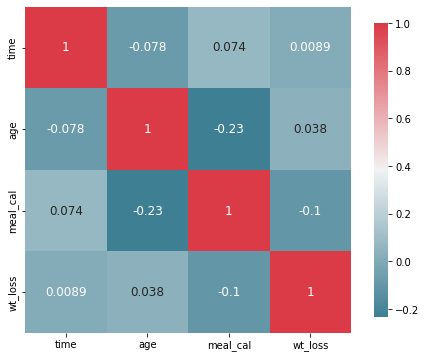

In [35]:
corr = df_imputed.corr()
_ , ax = plt.subplots(figsize =(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
_ = sns.heatmap(corr, cmap=cmap, square=True, cbar_kws={'shrink' : .9}, ax=ax, annot=True, annot_kws={'fontsize' : 12})

Recall the probabilistic model in linear regression:

Y = β0 + β1X1 + ... + βpXp + ε

where ε ∼ N(0, σ2). 

How can we take advantage of this model to impute with uncertainty?

It’s a 3 step process:
1. Fit a model to predict the predictor variable with
missingness from all the other predictors.
2. Predict the missing values from the model in the
previous part.
3. Add in a measure of uncertainty to this prediction by
randomly sampling from a N(0, σˆ2) distribution,
where σˆ2 is the mean square error (MSE) from the model.

In [113]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [115]:
from sklearn.compose import ColumnTransformer

categorical_columns = ['inst', 'status', 'sex', 'ph_ecog', 'ph_karno', 'pat_karno']
numerical_columns = ['time', 'age', 'meal_cal', 'wt_loss']

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [139]:
y = df_imputed['meal_cal']
# X = df_imputed.drop(['meal_cal'], axis=1)
X = df_imputed

In [140]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
model = make_pipeline(preprocessor, LinearRegression(fit_intercept=True))

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

In [142]:
model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Impute Categorical Data Using kNN

## II. Explore Data

In [101]:
# Global variables for plot formatting
#-------------------------------------------------------------------------------

# Title
title_font = {'fontname': 'Arial', 'size': '16',
              'color': 'black', 'weight': 'normal'}

# Sub-title
subtitle_font = {'fontname': 'Arial', 'size': '14',
              'color': 'black', 'weight': 'normal'}

# x-axis
x_lab_font = {'fontname': 'Arial', 'size': '12',
                'color': 'black', 'weight': 'normal'}

# y-axis
y_lab_font = {'fontname': 'Arial', 'size': '12',
                'color': 'black', 'weight': 'normal'}

# TODO: Create proxy artist: (https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists)
# Legend
leg_font = {'fontname': 'Arial', 'size': '12'}

# Single line plot figure size
single_fig_size = (10, 6)

AxesSubplot(0.125,0.125;0.775x0.755)


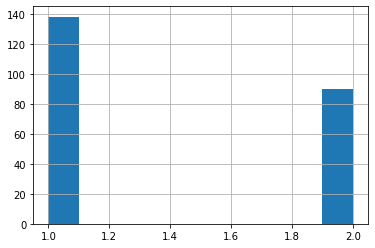

In [48]:
# Plot histogrm of sex column
print(df['sex'].hist())

In [113]:
vars_nas_status_2 = df[df['status'] == 2].isna().sum().sort_values(ascending=False)
vars_nas_status_2 = vars_nas_status_2[vars_nas_status_2 > 0]
vars_nas_status_2

meal_cal     31
wt_loss      13
pat_karno     3
inst          1
ph_ecog       1
ph_karno      1
dtype: int64

## Kaplan-Meier Estimator

In [49]:
# Create KaplanMeieerFitter object
kmf = KaplanMeierFitter()

In [50]:
# Create is.dead column
#-------------------------------------------------------------------------------

# If status == 1, then is.dead == 0
# If status == 2, then is.dead == 1
df.loc[df.status == 1, 'is.dead'] = 0
df.loc[df.status == 2, 'is.dead'] = 1

# Check changes
df.head()

,inst,time,status,age,sex,ph_ecog,ph_karno,pat_karno,meal_cal,wt_loss,is.dead
1,3,306,2,74,1,1,90,100,1175.0,NaN,1.0
2,3,455,2,68,1,0,90,90,1225.0,15.0,1.0
3,3,1010,1,56,1,0,90,90,NaN,15.0,0.0
4,5,210,2,57,1,1,90,60,1150.0,11.0,1.0
5,1,883,2,60,1,0,100,90,NaN,0.0,1.0


In [51]:
# Fit parameters to kmf object
kmf.fit(durations = df['time'], event_observed = df['is.dead'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 228 total observations, 63 right-censored observations>

## Event Table

In [52]:
# Print event table
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,228,228
5.0,1,1,0,0,228
11.0,3,3,0,0,227
12.0,1,1,0,0,224
13.0,2,2,0,0,223
...,...,...,...,...,...
840.0,1,0,1,0,5
883.0,1,1,0,0,4
965.0,1,0,1,0,3


#### NOTE:
- removed = observed + censored
- censored = person that did not die
- observed = person that did die

- entrance = the number of new patients in a given timeline; new patients could be diagnosed during experiment
- at_risk = # current patiens observed; at_risk = current patients at_risk + entrance - removed

In [53]:
# Print descriptive stats of kmf event table
kmf.event_table.describe()

,removed,observed,censored,entrance,at_risk
count,187.000000,187.000000,187.000000,187.000000,187.000000
mean,1.219251,0.882353,0.336898,1.219251,108.288770
std,0.452060,0.636741,0.506811,16.673011,66.490941
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,0.000000,0.000000,50.500000
50%,1.000000,1.000000,0.000000,0.000000,107.000000
75%,1.000000,1.000000,1.000000,0.000000,163.000000
max,3.000000,3.000000,2.000000,228.000000,228.000000


## Predicting probabilities
TODO: [Forest Plot](https://cran.r-project.org/web/packages/survivalAnalysis/vignettes/multivariate.html)

### Survival probability for t=0

In [54]:
# Calculate survival probability at a given time
event_at_0 = kmf.event_table.iloc[0,:]

# Calculate survival probability for t-0
surv_for_0 = (event_at_0.at_risk - event_at_0.observed) / event_at_0.at_risk
surv_for_0

1.0

### Survival probability for t=5

In [55]:
# Calculate survival probability at a given time
event_at_5 = kmf.event_table.iloc[1,:]

# Calculate survival probability for t=5
surv_for_5 = (event_at_5.at_risk - event_at_5.observed) / event_at_5.at_risk
surv_for_5

0.9956140350877193

### Survival probability for t=11

In [56]:
# Calculate survival probability at a given time
event_at_11 = kmf.event_table.iloc[2,:]

# Calculate survival probability for t-0
surv_for_11 = (event_at_11.at_risk - event_at_11.observed) / event_at_11.at_risk
surv_for_11

0.986784140969163

In [57]:
# Probabilities of survival
print("Survival probability for t=0: ", kmf.predict(0))
print("Survival probability for t=5: ", kmf.predict(5))
print("Survival probability for t=11: ", kmf.predict(11))

Survival probability for t=0:  1.0
Survival probability for t=5:  0.9956140350877193
Survival probability for t=11:  0.9824561403508766


In [58]:
# Can do the above like this, too:
kmf.predict([0, 5, 11, 12])

0     1.000000
5     0.995614
11    0.982456
12    0.978070
Name: KM_estimate, dtype: float64

### Table of survival probabilities

In [59]:
# Or, you can make predictions for the entire timeline like this:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
5.0,0.995614
11.0,0.982456
12.0,0.978070
13.0,0.969298
...,...
840.0,0.067127
883.0,0.050346
965.0,0.050346


### Plot of survival probabilities

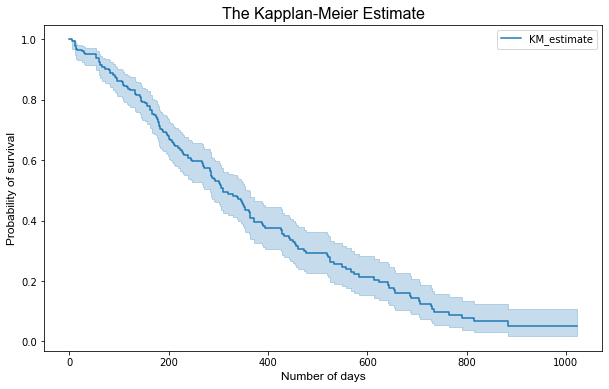

In [112]:
# Plot graph of probabilities
kmf.plot(figsize=single_fig_size)
plt.title('The Kapplan-Meier Estimate', title_font)
plt.xlabel('Number of days', x_lab_font)
plt.ylabel('Probability of survival', y_lab_font)
plt.legend(loc='upper right')
plt.savefig('plots/kmf_plot')
plt.show()

# TODO: Why aren't the axis labels larger??

## Median number of survival days
### Provides the number of days where, on average, 50% of the patients survived

In [113]:
# Print the median number of days where, on average, 50% of the patients survived
print('The median survival time: ', kmf.median_survival_time_)

The median survival time:  310.0


## Table of survival probability with confidence interval

In [114]:
# Print survival probabilities with confidence intervals
kmf.confidence_interval_survival_function_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
5.0,0.969277,0.999381
11.0,0.953935,0.993379
12.0,0.948120,0.990813
13.0,0.936682,0.985244
...,...,...
840.0,0.030728,0.123060
883.0,0.017866,0.108662
965.0,0.017866,0.108662
1010.0,0.017866,0.108662


## Plot of survival probability with confidence interval

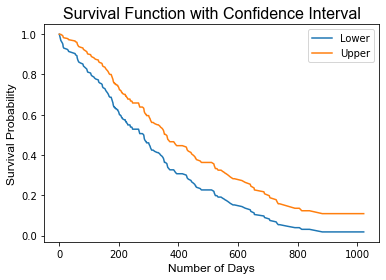

In [120]:
# Plot survival function with confidence interval
confidence_surv_func = kmf.confidence_interval_survival_function_

# plt.plot(figsize=single_fig_size)
plt.plot(confidence_surv_func['KM_estimate_lower_0.95'], label='Lower')
plt.plot(confidence_surv_func['KM_estimate_upper_0.95'], label='Upper')
plt.title('Survival Function with Confidence Interval', title_font)
plt.xlabel('Number of Days', x_lab_font)
plt.ylabel('Survival Probability', y_lab_font)
plt.legend()
plt.savefig('plots/kmf_confidence_plot')
plt.show()

## Probability of a person dying at time t
### number of subjects that died at time t / number of subjects at risk just before time t

In [23]:
# Print cumulative density

# Probability of a subject dying
# p(1022) = p(0) + ... + p(1022)
kmf.cumulative_density_

,KM_estimate
timeline,
0.0,0.000000
5.0,0.004386
11.0,0.017544
12.0,0.021930
13.0,0.030702
...,...
840.0,0.932873
883.0,0.949654
965.0,0.949654


## Plot of cumulative density

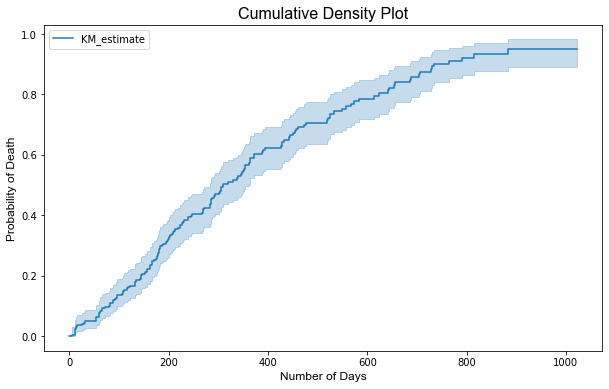

In [128]:
# Plot graph of cumulative density

kmf.plot_cumulative_density(figsize=single_fig_size)
plt.title('Cumulative Density Plot', title_font)
plt.xlabel('Number of Days', x_lab_font)
plt.ylabel("Probability of Death", y_lab_font)
plt.legend(loc='upper left')
plt.savefig('plots/kmf_cumulative_density_plot')
plt.show()

## Table of cumulative densities with a confidence interval

In [25]:
# Cumalative density with confidence interval
kmf.confidence_interval_cumulative_density_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,0.000000,0.000000
5.0,0.030723,0.000619
11.0,0.046065,0.006621
12.0,0.051880,0.009187
13.0,0.063318,0.014756
...,...,...
840.0,0.969272,0.876940
883.0,0.982134,0.891338
965.0,0.982134,0.891338
1010.0,0.982134,0.891338


## Plot cumulative density with a confidence interval

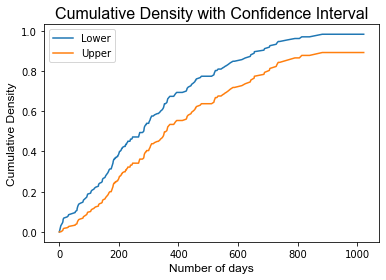

In [131]:
# Plot cumulative density with confidence interval

confidence_cumulative_density = kmf.confidence_interval_cumulative_density_

plt.plot(kmf.confidence_interval_cumulative_density_['KM_estimate_lower_0.95'], label='Lower')
plt.plot(kmf.confidence_interval_cumulative_density_['KM_estimate_upper_0.95'], label='Upper')
plt.title('Cumulative Density with Confidence Interval', title_font)
plt.xlabel('Number of days', x_lab_font)
plt.ylabel('Cumulative Density', y_lab_font)
plt.legend()
plt.savefig('plots/kmf_cumulative_density_confidence_plot')
plt.show()

## Cumulative density for a particular time

In [27]:
# Find cumulative density at a specific time
kmf.cumulative_density_at_times(times=1022)

1022    0.949654
Name: KM_estimate, dtype: float64

## Median time to an event
### IE: the amount of time remaining from the median survival time

In [28]:
# Conditional median time to event of interest
kmf.conditional_time_to_event_

,KM_estimate - Conditional median duration remaining to event
timeline,
0.0,310.0
5.0,305.0
11.0,309.0
12.0,308.0
13.0,316.0
...,...
840.0,inf
883.0,inf
965.0,inf


# Plot of median time to the event

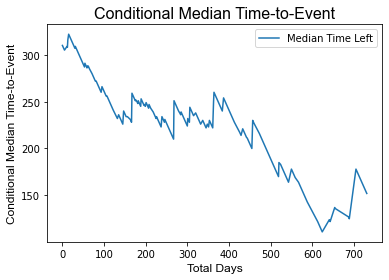

In [136]:
# Conditional median time left for event
median_time_to_event = kmf.conditional_time_to_event_
plt.plot(median_time_to_event, label='Median Time Left')
plt.title('Conditional Median Time-to-Event', title_font)
plt.xlabel('Total Days', x_lab_font)
plt.ylabel('Conditional Median Time-to-Event', y_lab_font)
plt.legend()
plt.savefig('plots/kmf_conditional_median_time_to_event_plot')
plt.show()

## Nelson-Aalen Estimator

In [137]:
# Create Nelson-Aalen Fitter object
naf = NelsonAalenFitter()

In [138]:
# Fit data to object
naf.fit(df['time'], event_observed=df['is.dead'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 228 total observations, 63 right-censored observations>

In [139]:
# Print cumulative hazard
naf.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
5.0,0.004386
11.0,0.017660
12.0,0.022125
13.0,0.031114
...,...
840.0,2.641565
883.0,2.891565
965.0,2.891565


## Plot of cumulative hazard

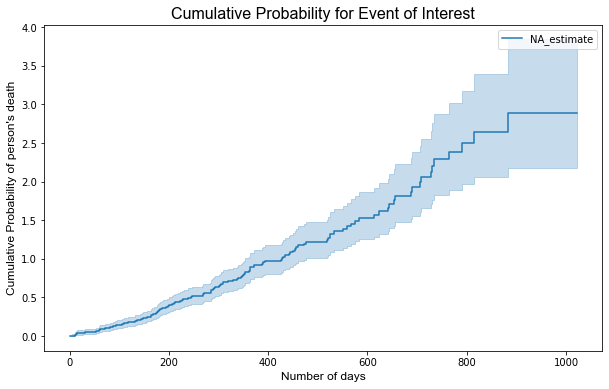

In [143]:
# Plot the cumulative hazard graph
naf.plot_cumulative_hazard(figsize=single_fig_size)
plt.title('Cumulative Probability for Event of Interest', title_font)
plt.xlabel('Number of days', x_lab_font)
plt.ylabel('Cumulative Probability of person\'s death', y_lab_font)
plt.savefig('plots/naf_plot')
plt.show()

## Predict values

In [35]:
# Predict the value at a certain point
print('Time = 500 days: ', naf.predict(500))
print('Time = 1022 days: ', naf.predict(1022))

Time = 500 days:  1.219546171331098
Time = 1022 days:  2.8915648373471052


## Table of cumulative hazard probabilities with confidence interval

In [36]:
# Cumulative hazard with confidence interval
naf.confidence_interval_

,NA_estimate_lower_0.95,NA_estimate_upper_0.95
0.0,0.000000,0.000000
5.0,0.000618,0.031136
11.0,0.006628,0.047055
12.0,0.009209,0.053156
13.0,0.014832,0.065266
...,...,...
840.0,2.058738,3.389389
883.0,2.176987,3.840697
965.0,2.176987,3.840697
1010.0,2.176987,3.840697


## Plot of cumulative hazard probability with confidence interval

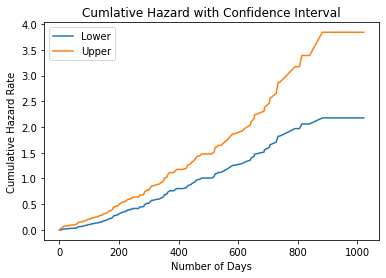

In [19]:
# Plot cumulative hazard rate with confidence interval
confidence_interval = naf.confidence_interval_

plt.plot(confidence_interval["NA_estimate_lower_0.95"], label='Lower')
plt.plot(confidence_interval["NA_estimate_upper_0.95"], label='Upper')
plt.title('Cumlative Hazard with Confidence Interval')
plt.xlabel('Number of Days')
plt.ylabel('Cumulative Hazard Rate')
plt.legend()
plt.savefig('plots/naf_ci_plot')

## Plot Cumulative Hazard vs. Cumulative Density

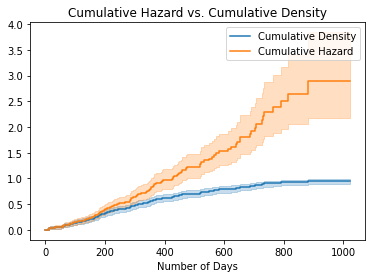

In [20]:
# Plot cumulative hazard vs cumultive density
kmf.plot_cumulative_density(label='Cumulative Density')
naf.plot_cumulative_hazard(label='Cumulative Hazard')
plt.title('Cumulative Hazard vs. Cumulative Density')
plt.xlabel('Number of Days')
plt.savefig('plots/naf_vs_kmf_plot')

## Kaplan-Meier Estimator with Groups
### Determine if there is any difference in survival probability if we divide our data into groups based on certain criteria.
### Here, the data are divided into two groups based on sex:
1. Male
2. Female

### Create Kaplan-Meier Fitter objects for each group

In [22]:
# Create two objects, one for male group and one for female group

#kmf_m for male data
kmf_m = KaplanMeierFitter()
kmf_f = KaplanMeierFitter()

### Divide data into two groups

In [23]:
# Divide data
male_df = df.query('sex == 1')
female_df = df.query('sex == 2')

In [24]:
# Inspect male data
male_df.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN,1.0
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0,0.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0,1.0


In [25]:
# Inspect female data
female_df.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
6,7,7.0,310,2,68,2,2.0,70.0,60.0,384.0,10.0,1.0
7,8,11.0,361,2,71,2,2.0,60.0,80.0,538.0,1.0,1.0
11,12,16.0,654,2,68,2,2.0,70.0,70.0,NaN,23.0,1.0
12,13,11.0,728,2,68,2,1.0,90.0,90.0,NaN,5.0,1.0
18,19,1.0,61,2,56,2,2.0,60.0,60.0,238.0,10.0,1.0


In [26]:
# Fit data into objects
male_kmf = kmf_m.fit(durations=male_df['time'], event_observed=male_df['is.dead'], label='Male')
female_kmf = kmf_f.fit(durations=female_df['time'], event_observed=female_df['is.dead'], label='Female')

### Male group event table

In [27]:
# Event table for male group
male_kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,138,138
11.0,3,3,0,0,138
12.0,1,1,0,0,135
13.0,2,2,0,0,134
15.0,1,1,0,0,132
...,...,...,...,...,...
814.0,1,1,0,0,5
840.0,1,0,1,0,4
883.0,1,1,0,0,3


### Female group event table

In [28]:
# Event table for female group
female_kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,90,90
5.0,1,1,0,0,90
60.0,1,1,0,0,89
61.0,1,1,0,0,88
62.0,1,1,0,0,87
...,...,...,...,...,...
735.0,1,1,0,0,5
740.0,1,0,1,0,4
765.0,1,1,0,0,3


### Predicting survival probabilities

In [29]:
# Predict value based on time
print('Male survival probability at 11 days: ', kmf_m.predict(11))
print('Female survival probability at 11 days: ', kmf_f.predict(11))

Male survival probability at 11 days:  0.9782608695652172
Female survival probability at 11 days:  0.9888888888888887


In [30]:
# calculte survival probability for entire data set in group
kmf_male_survival_rates = kmf_m.survival_function_
kmf_female_survival_rates = kmf_f.survival_function_

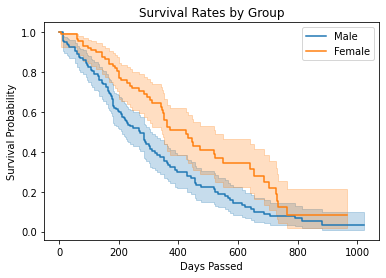

In [31]:
### Plot survival probabilities
kmf_m.plot()
kmf_f.plot()

plt.title('Survival Rates by Group')
plt.xlabel('Days Passed')
plt.ylabel('Survival Probability')
plt.savefig('plots/survival_rates_by_sex_plot')

Above, we can see that female lung cancer patients have a higher probability of surviving lung cancer than men. This information can be used to inform future research and policies.

## Cumlative Densities by Group

In [67]:
# # Cumlative density for male group
kmf_m.cumulative_density_

,Male
timeline,
0.0,0.000000
11.0,0.021739
12.0,0.028986
13.0,0.043478
15.0,0.050725
...,...
814.0,0.946429
840.0,0.946429
883.0,0.964286


In [68]:
# Cumulative density for female group
kmf_f.cumulative_density_

,Female
timeline,
0.0,0.000000
5.0,0.011111
60.0,0.022222
61.0,0.033333
62.0,0.044444
...,...
735.0,0.875178
740.0,0.875178
765.0,0.916786


## Plot Group Cumulative Densities

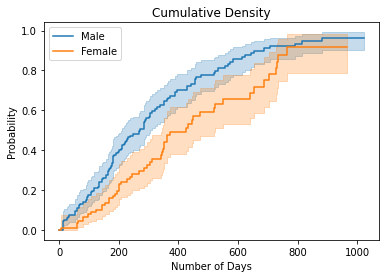

In [33]:
# Plot cumulative density for each group
kmf_m.plot_cumulative_density()
kmf_f.plot_cumulative_density()
plt.title('Cumulative Density')
plt.xlabel('Number of Days')
plt.ylabel('Probability')
plt.legend()
plt.savefig('plots/cumulative_density_by_sex_plot')

## Hazard Function

Create objects for each group and fit relevant data

In [35]:
# Create objects
naf_m = NelsonAalenFitter()
naf_f = NelsonAalenFitter()

# Fit data
naf_m.fit(male_df['time'], event_observed=male_df['is.dead'])
naf_f.fit(female_df['time'], event_observed=female_df['is.dead'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 90 total observations, 37 right-censored observations>

## Cumulative Hazard Probability

In [36]:
# Cumulative hazard probability for male group
naf_m.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
11.0,0.021899
12.0,0.029306
13.0,0.044287
15.0,0.051863
...,...
814.0,2.831337
840.0,2.831337
883.0,3.164670


In [37]:
# Cumulative hazard probability for female group
naf_f.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
5.0,0.011111
60.0,0.022347
61.0,0.033711
62.0,0.045205
...,...
735.0,1.988977
740.0,1.988977
765.0,2.322310


## Plot Cumulative Hazard Probability for each group

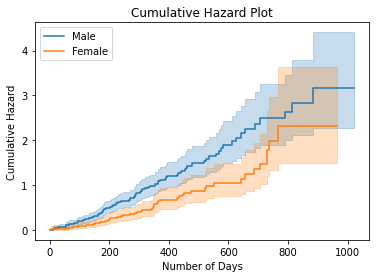

In [38]:
# Plot cumulative hazard probability for each group
naf_m.plot_cumulative_hazard(label='Male')
naf_f.plot_cumulative_hazard(label='Female')
plt.title('Cumulative Hazard Plot')
plt.xlabel('Number of Days')
plt.ylabel('Cumulative Hazard')
plt.legend(loc='upper left')
plt.savefig('plots/cumulative_hazard_by_sex_plot')

## Median time to event for male group

In [39]:
# Conditional median time to event of interest
kmf_m.conditional_time_to_event_

,Male - Conditional median duration remaining to event
timeline,
0.0,270.0
11.0,272.0
12.0,271.0
13.0,271.0
15.0,270.0
...,...
814.0,inf
840.0,inf
883.0,inf


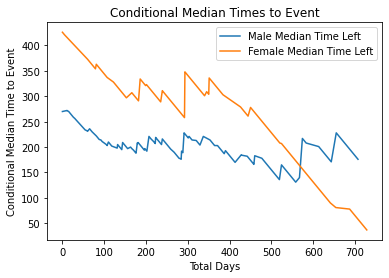

In [41]:
## Plot median time to event for each group
plt.plot(kmf_m.conditional_time_to_event_, label='Male Median Time Left')
plt.plot(kmf_f.conditional_time_to_event_, label='Female Median Time Left')
plt.title('Conditional Median Times to Event')
plt.xlabel('Total Days')
plt.ylabel('Conditional Median Time to Event')
plt.legend()
plt.savefig('plots/conditional_median_time_to_event_by_sex_plot')

## Plot survival probability with confidence interval for male group

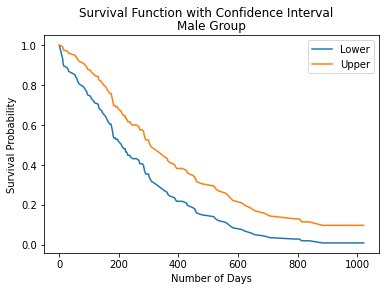

In [43]:
# Plot survival function with confidence interval for male group
confidence_surv_func = kmf_m.confidence_interval_survival_function_

plt.plot(confidence_surv_func['Male_lower_0.95'], label='Lower')
plt.plot(confidence_surv_func['Male_upper_0.95'], label='Upper')
plt.suptitle('Survival Function with Confidence Interval')
plt.title('Male Group')
plt.xlabel('Number of Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.savefig('plots/survival_func_conf_interval_male_plot')

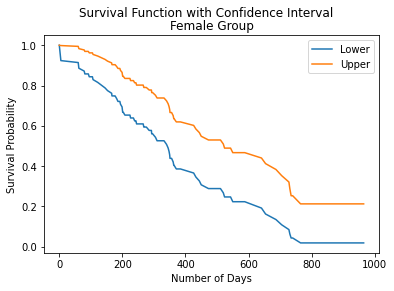

In [44]:
# Plot survival function with confidence interval for male group
confidence_surv_func = kmf_f.confidence_interval_survival_function_

plt.plot(confidence_surv_func['Female_lower_0.95'], label='Lower')
plt.plot(confidence_surv_func['Female_upper_0.95'], label='Upper')
plt.suptitle('Survival Function with Confidence Interval')
plt.title('Female Group')
plt.xlabel('Number of Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.savefig('plots/survival_func_conf_interval_female_plot')

## Comparison of cumulative density vs cumultive hazard

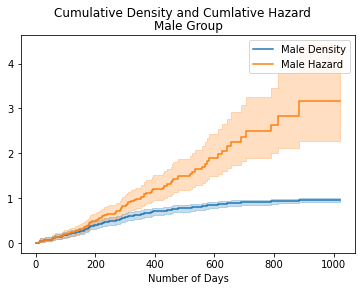

In [45]:
# Plot the cumulative hazard and cumulative density
kmf_m.plot_cumulative_density(label='Male Density')
naf_m.plot_cumulative_hazard(label='Male Hazard')
plt.suptitle('Cumulative Density and Cumlative Hazard')
plt.title('Male Group')
plt.xlabel('Number of Days')
plt.savefig('plots/cum_density_cum_hazard_male_plot')

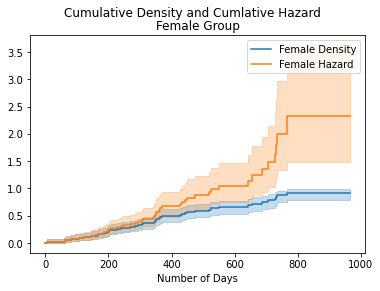

In [46]:
# Plot the cumulative hazard and cumulative density
kmf_f.plot_cumulative_density(label='Female Density')
naf_f.plot_cumulative_hazard(label='Female Hazard')
plt.suptitle('Cumulative Density and Cumlative Hazard')
plt.title('Female Group')
plt.xlabel('Number of Days')
plt.savefig('plots/cum_density_cum_hazard_female_plot')

## Log-Rank Test

In [90]:
# Define variables for Log-rank test
time_A = male_df['time']
event_A = male_df['is.dead']

time_B = female_df['time']
event_B = female_df['is.dead']

In [91]:
# Perform Log-rank test
results = logrank_test(time_A, time_B, event_observed_A=event_A, event_observed_B=event_B)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.33 <0.005      9.57

In [92]:
# Print p-value
print('P-value: ', results.p_value)

P-value:  0.0013111645203554782


With a p-value of 0.0013 (shown above), we must reject the null hypothesis that there is no statistically significant difference between the probability of survival for the male group and that of the female group.

This p-value, in fact, is strong evidence that 'sex' was associated with the number of survival days.

## Cox's Proportional Hazard Regression

In [50]:
# Prepare data
# Need to drop 'Unnamed: 0' column
cox_df = data.drop(['Unnamed: 0'], axis=1)
cox_df.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN,1.0
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0,0.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0,1.0


In [51]:
# Remove null values
subset_cols = ['inst', 'time', 'status', 'age', 'sex', 'ph.ecog', 'ph.karno',
                'pat.karno', 'meal.cal', 'wt.loss']
cox_df = df.dropna(subset=subset_cols)
cox_df.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
5,6,12.0,1022,1,74,1,1.0,50.0,80.0,513.0,0.0,0.0
6,7,7.0,310,2,68,2,2.0,70.0,60.0,384.0,10.0,1.0
7,8,11.0,361,2,71,2,2.0,60.0,80.0,538.0,1.0,1.0


In [52]:
# Get list of columns needed
cox_cols = ['time', 'age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno', 'meal.cal',
            'wt.loss', 'is.dead']

# Subset cox_data
cox_df = cox_df[cox_cols]

## Create Cox-proportional Hazard object and fit data

In [53]:
# Fit data and print summary
cph = CoxPHFitter()
cph.fit(cox_df, 'time', event_col='is.dead')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 167 total observations, 47 right-censored observations>
             duration col = 'time'
                event col = 'is.dead'
      baseline estimation = breslow
   number of observations = 167
number of events observed = 120
   partial log-likelihood = -494.03
         time fit was run = 2021-11-01 03:57:04 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
sex        -0.55       0.57       0.20            -0.95            -0.16                 0.39                 0.85
ph.ecog     0.74       2.09       0.22             0.30             1.18                 1.35                 3.26
ph.karno    0.02       1.02       0.01             0.00             0.04                 1.00                 1.05
pat.karno  -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
meal.cal    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
wt.loss    -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00

              z      p   -log2(p)
covariate                        
age        0.93   0.35       1.51
sex       -2.75   0.01       7.37
ph.ecog    3.29 <0.005       9.95
ph.karno   2.00   0.05       4.45
pat.karno -1.49   0.14       2.87
meal.cal   0.11   0.91       0.13
wt.loss   -1.83   0.07       3.89
---
Concordance = 0.65
Partial AIC = 1002.07
log-likelihood ratio test = 28.16 on 7 df
-log2(p) of ll-ratio test = 12.25

From the summary above, we can see that 'sex' and 'ph.ecog' have p-values less than 0.05. So, we should divide the data based on these two variables.

1. The 'sex' variable has a p-value of 0.01 and a Hazard Ratio (HR) of 0.57. This indicates a strong relationship between the subject's sex and decreased risk of death.
    * EG: Holding the other covariates constant, being female reduces the hazard by a factor of 0.57, or 43%. This means that females have higher chances of survival.
2. The 'ph.ecog' variable has a p-value <0.005 and a Hazard Ratio of 2.09. This indicates a strong relationship between the value of ph.ecog and increased risk of death.
    * EG: All other variables held constant, a subject witth a higher ph.ecog has 109% higher risk of death. This means that a higher value of ph.ecog is associated with poor survival.

## Plot Cox's Proportional Hazard

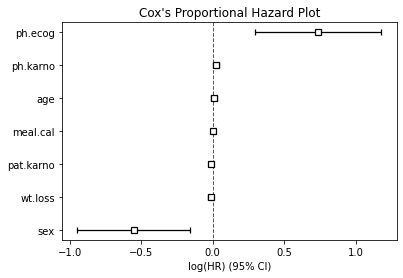

In [54]:
# Plot cph
cph.plot()
plt.title("Cox's Proportional Hazard Plot")
plt.savefig('plots/cox_proportional_hazard_plot')

## Check theory with real observations

In [55]:
# Check conclusions with real data from observations
d_df = cox_df.iloc[10:15,:]
d_df

,time,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,is.dead
17,707,63,1,2.0,50.0,70.0,1025.0,22.0,1.0
18,61,56,2,2.0,60.0,60.0,238.0,10.0,1.0
20,301,67,1,1.0,80.0,80.0,1025.0,17.0,1.0
21,81,49,2,0.0,100.0,70.0,1175.0,-8.0,1.0
23,371,58,1,0.0,90.0,100.0,975.0,13.0,1.0


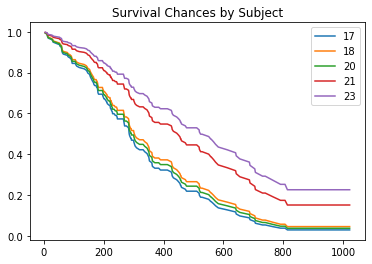

In [56]:
# Plot d_data
cph.predict_survival_function(d_data).plot()
plt.title('Survival Chances by Subject')
plt.savefig('plots/survival_chances_by_subject_plot')

Above, we can see that subject 23 hs the highest chance of survival and tht subject 17 has the lowest. By checking the main table, we can see a significant change in the value of the ph.ecog value. We can, also see that subjects 21 and 23 have higher chances of survival and that they have the lowest values of ph.ecog.